# 1. Inspecting transfusion.data file¶

Blood transfusions play a vital role in saving lives, whether it’s by replenishing blood lost during major surgeries or treating various diseases and blood disorders. One of the main challenges for healthcare professionals is maintaining an adequate blood supply at all times. According to WebMD, around 5 million Americans require blood transfusions annually.

The dataset used in this project comes from a mobile blood donation service in Taiwan, where the Blood Transfusion Service Center visits universities to collect donations. The goal is to predict whether a donor will donate blood again during the next visit to the campus. The data is stored in the transfusion.data file and follows the RFMTC marketing model, a variation of the standard RFM model. First, we inspect the dataset before diving into its structure.

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

transfusion = pd.read_csv('/kaggle/input/transfusion/transfusion.data')
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


The RFM model, which stands for Recency, Frequency, and Monetary Value, is commonly used in marketing to identify valuable customers. In this context, our "customers" are blood donors.

RFMTC is a variation of the RFM model, and the dataset columns are structured as follows:

R (Recency): Number of months since the last donation.
F (Frequency): Total number of donations.
M (Monetary): Total blood donated (measured in cubic centimeters).
T (Time): Number of months since the first donation.
Binary variable: Indicates whether the donor gave blood in March 2007 (1 for donating, 0 for not).
Each column in the dataset is numeric, which is ideal for building a machine learning model. Let's confirm this by inspecting the data.

# 2. Exploratory Data Analysis


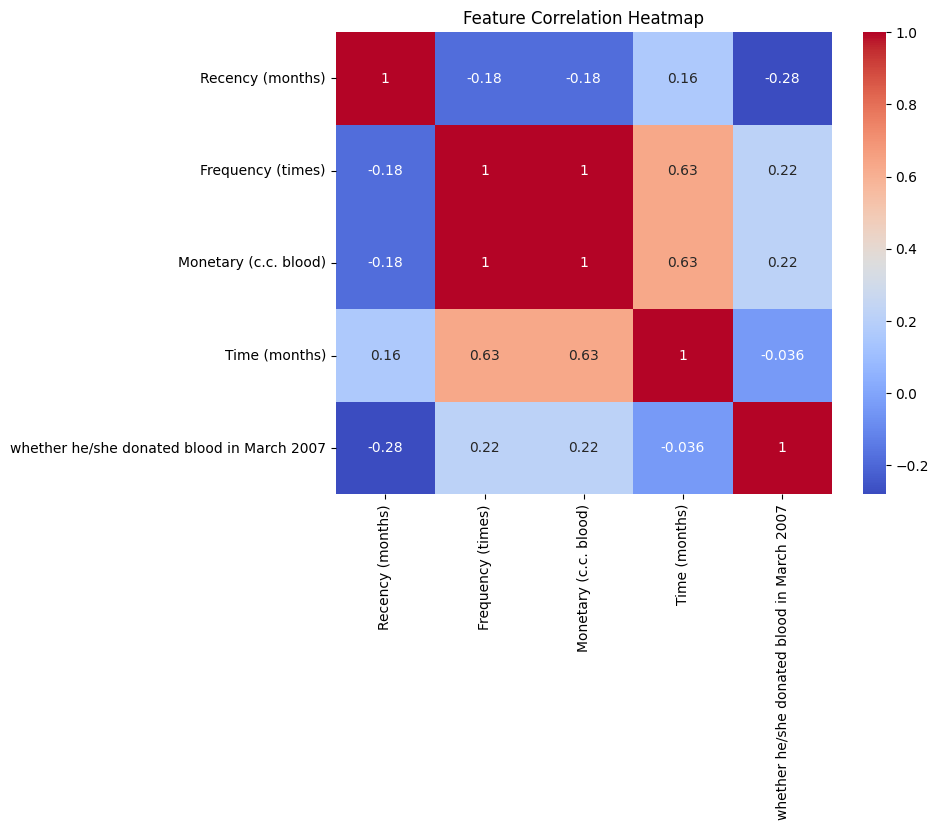

<Figure size 1000x800 with 0 Axes>

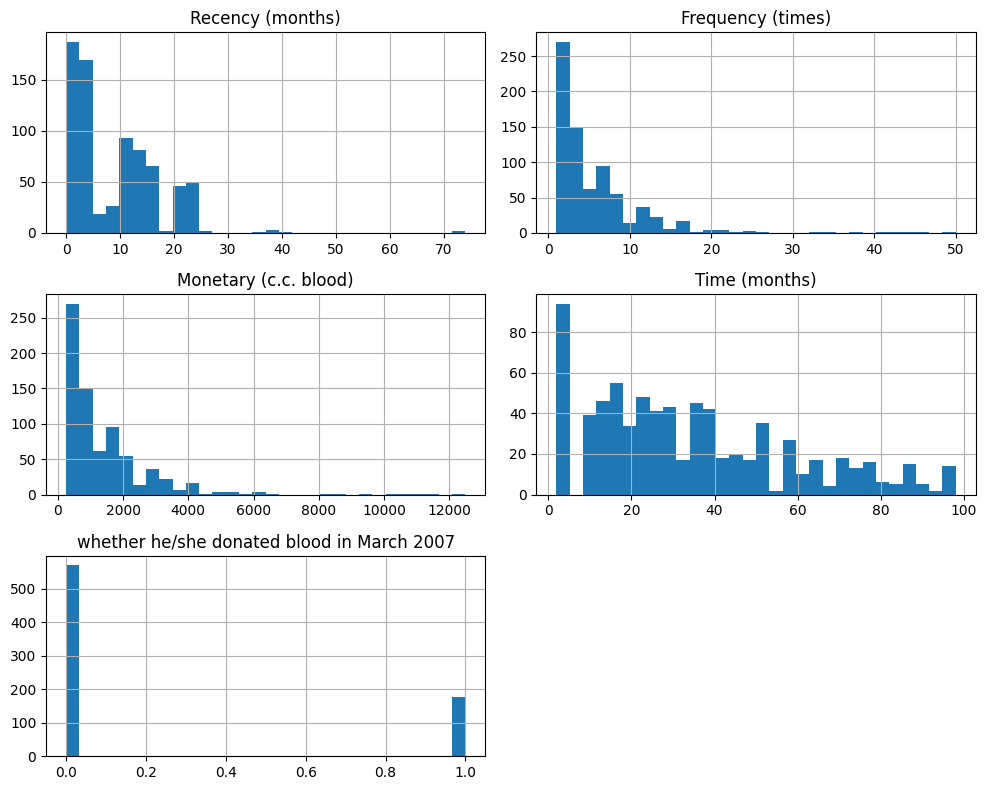

In [4]:

# Exploratory Data Analysis
# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(transfusion.corr(), annot=True, cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

# Distribution of features
plt.figure(figsize=(10, 8))
transfusion.hist(bins=30, figsize=(10,8))
plt.tight_layout()
plt.show()


### 1. Matrice de corrélation (heatmap) :
* Explication générale : 
La matrice de corrélation représente les relations entre les différentes variables du dataset. Chaque cellule de la matrice montre le degré de corrélation entre deux variables, avec des valeurs allant de -1 (corrélation négative parfaite) à 1 (corrélation positive parfaite).
* Analyse :
Il y a une forte corrélation (1.0) entre les variables Frequency (times) et Monetary (c.c. blood), ce qui est logique puisque plus une personne donne fréquemment, plus la quantité totale de sang donné sera élevée.
Time (months) est aussi modérément corrélé avec Frequency (times) et Monetary (c.c. blood) (0.63), indiquant que plus une personne donne de manière régulière, plus la période de suivi augmente.
Il y a une corrélation légèrement négative entre Recency (months) et le fait d’avoir donné du sang en mars 2007 (-0.28), suggérant que plus le don est ancien, moins il est probable que la personne ait donné en mars 2007.
### 2. Histogrammes :
* Explication générale :
Les histogrammes montrent la distribution des différentes variables du dataset.
Analyse des histogrammes :
Recency (months) : La majorité des personnes ont fait un don de sang il y a moins de 10 mois, mais il y a des valeurs plus élevées allant jusqu'à 70 mois.
Frequency (times) :
La plupart des donneurs ont donné moins de 10 fois, mais certains ont donné jusqu'à 50 fois.
Monetary (c.c. blood) : Cela représente la quantité totale de sang donnée. La plupart des gens ont donné moins de 2000 c.c. de sang (correspondant à environ 4 dons), mais quelques personnes ont donné des quantités bien plus élevées.
Time (months) : La période de suivi varie largement, allant de quelques mois à plus de 80 mois, avec une concentration plus importante entre 0 et 40 mois.
Don en mars 2007 : Il s'agit d'une variable binaire (0 ou 1) qui indique si une personne a donné du sang en mars 2007. La majorité des personnes n'ont pas donné à cette date (valeur 0), mais une proportion non négligeable l’a fait (valeur 1).**

In [6]:
# Feature Engineering: Adding interaction and ratio features
transfusion['Recency_Frequency_Ratio'] = transfusion['Recency (months)'] / (transfusion['Frequency (times)'] + 1)
transfusion['Recency_Time_Ratio'] = transfusion['Recency (months)'] / (transfusion['Time (months)'] + 1)

# Split dataset into features and target
X = transfusion.drop(columns='whether he/she donated blood in March 2007')
y = transfusion['whether he/she donated blood in March 2007']


# 3. Train-Test Split with Cross-Validation


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Logistic Regression with Cross-Validation
logreg = LogisticRegression(solver='liblinear', random_state=42)
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')

print(f'Cross-Validation AUC scores: {cv_scores}')
print(f'Average AUC score: {cv_scores.mean():.4f}')


Cross-Validation AUC scores: [0.79392765 0.76341682 0.7627451  0.6453159  0.76862745]
Average AUC score: 0.7468


##  Cross-Validation AUC scores :
Interprétation : Ces scores montrent la capacité du modèle à distinguer entre les classes (dans ce cas, probablement entre ceux qui ont donné du sang et ceux qui ne l'ont pas fait).

Le premier score est 0.7939, ce qui est assez bon, indiquant que le modèle est capable de bien classifier les données pour cette itération.
Les autres scores varient entre 0.6453 et 0.7686, montrant que le modèle performe de manière acceptable, mais avec une performance plus faible pour certaines itérations (comme 0.6453).
Conclusion : Bien que les scores soient relativement bons dans certaines itérations, ils montrent aussi une certaine variabilité, ce qui peut indiquer que le modèle pourrait bénéficier d'un ajustement ou d'une optimisation pour une meilleure stabilité.

# 4. Hyperparameter Tuning with GridSearchCV


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modèle de régression logistique avec augmentation des itérations
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

# Recherche des hyperparamètres avec GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

# Affichage des meilleurs hyperparamètres
print(f'Best hyperparameters: {grid_search.best_params_}')

# Évaluation sur les données de test
best_logreg = grid_search.best_estimator_
y_pred_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f'Logistic Regression AUC score on test data: {auc_score:.4f}')


Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Logistic Regression AUC score on test data: 0.7963


# 5. Model Explainability with SHAP


In [9]:
# First, install SHAP
!pip install shap


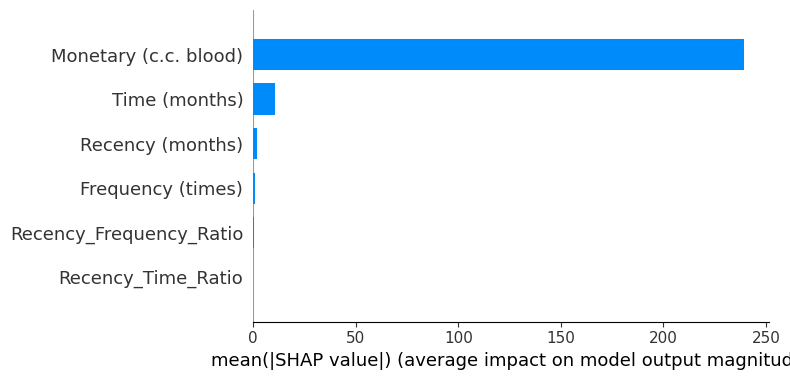

In [20]:
import shap

# Use SHAP to explain model predictions
explainer = shap.Explainer(best_logreg, X_train)
shap_values = explainer(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")


The summary plot displays the mean absolute SHAP values for each feature, showing how influential each feature is in the model. The features are ranked in order of their impact.

Monetary (c.c. blood): This feature has the highest mean SHAP value, meaning it's the most important factor affecting the model's predictions.
Time (months): This has a smaller influence, but it's the second most important.
Other features like Recency (months), Frequency (times), Recency_Frequency_Ratio, Recency_Time_Ratio have very low SHAP values, meaning they have much less impact on the model's predictions.

In [28]:
# First, install Streamlit
!pip install streamlit


ERROR: Could not find a version that satisfies the requirement streamlit (from versions: none)
ERROR: No matching distribution found for streamlit


In [11]:
import streamlit as st

# Load model and data
st.title("Blood Donation Prediction")
recency = st.number_input('Recency (months)')
frequency = st.number_input('Frequency (times)')
monetary = st.number_input('Monetary (c.c. blood)')
time = st.number_input('Time (months)')

# Create a new data instance
input_data = pd.DataFrame({
    'Recency (months)': [recency],
    'Frequency (times)': [frequency],
    'Monetary (c.c. blood)': [monetary],
    'Time (months)': [time]
})

# Log normalization
input_data['monetary_log'] = np.log(input_data['Monetary (c.c. blood)'] + 1)
input_data.drop(columns='Monetary (c.c. blood)', inplace=True)

# Predict
if st.button('Predict'):
    prediction = best_logreg.predict(input_data)
    st.write(f"Prediction: {'Donated' if prediction[0] == 1 else 'Did not donate'}")


ModuleNotFoundError: No module named 'streamlit'